In [79]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## 1. Data Loading

In [61]:
df = pd.read_csv("analysis_dataset/music_running_weather.csv")
df.head()

,Sr. no.,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,start_latlng,end_latlng,sport_type,...,playlist_id,intensity,mood,lyrics,music_condition,temp,humidity,windspeed,precip,conditions
0,1,2023-12-09T09:09:19Z,Run,10879.7,4023,4617,91.4,"[40.70327935740352, -73.99619171395898]","[40.69340907968581, -73.97922154515982]",Run,...,5ymkuBk3C1Iu4KTdJBK9vy,5,4,1,fast,8.0,84.71,7.3,0.000,Overcast
1,2,2023-12-07T17:31:50Z,Run,1304.4,722,62993,0.0,"[40.7220459356904, -74.03641730546951]","[40.719722136855125, -74.03257705271244]",Run,...,5Egmw4o1GAN8QkhXGaxao6,3,3,1,medium,3.8,68.71,14.2,0.000,Overcast
2,3,2023-12-03T09:18:13Z,Run,17503.0,7370,7462,68.4,"[40.74991073459387, -73.98751585744321]","[40.73538766242564, -73.9793517999351]",Run,...,7pWNfjCrJmS4ILho1S4CvK,1,2,0,slow,11.5,83.85,9.0,0.759,"Rain, Overcast"
3,4,2023-12-02T09:41:14Z,Run,3457.8,1791,2170,3.9,"[40.72203076444566, -74.03641068376601]","[40.71398631669581, -74.03902692720294]",Run,...,5Egmw4o1GAN8QkhXGaxao6,3,3,1,medium,9.5,87.37,9.3,0.000,Overcast
4,5,2023-12-01T17:06:05Z,Run,10108.2,4128,4221,6.3,"[40.72190687991679, -74.03624514117837]","[40.71669920347631, -74.03264125809073]",Run,...,7pWNfjCrJmS4ILho1S4CvK,1,2,0,slow,7.8,78.20,6.4,0.472,"Rain, Overcast"


## 2. Feature sets

In [62]:
baseline_features = [
    "distance_km",
    "duration_min",
    "total_elevation_gain",
    "hour",
    "weekday",
]

music_features = baseline_features + [
    "intensity",
    "mood",
    "lyrics",
    "music_condition",
]

full_features = music_features + [
    "temp",
    "humidity",
    "windspeed",
    "precip",
    "conditions",
]
df = df.dropna(subset=full_features + ["pace_min_per_km"]).copy()
print(df.shape)

(96, 35)


In [63]:
def extract_features(df, features):
    data = df[features + ["pace_min_per_km"]].copy()
    categoricals = []
    for c in features:
        if data[c].dtype == "object":
            categoricals.append(c)

    data = pd.get_dummies(data, columns=categoricals, drop_first=True)
    X = data.drop(columns=["pace_min_per_km"])
    y = data["pace_min_per_km"].values
    return X, y

X_base, y = extract_features(df, baseline_features)
X_music, _ = extract_features(df, music_features)
X_full, _ = extract_features(df, full_features)

print("Baseline X:", X_base.shape)
print("Music X:", X_music.shape)
print("Full X:", X_full.shape)

Baseline X: (96, 5)
Music X: (96, 10)
Full X: (96, 18)


## 3. Model Training and Evaluation

In [80]:
# Train - test split
x_train_base, x_test_base, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)
x_train_music, x_test_music, y_train, y_test = train_test_split(X_music, y, test_size=0.2, random_state=42)
x_train_full, x_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

In [84]:
def evaluate_model(model, model_name, x_train, y_train, x_test, y_test, scale=False):
    X_train, X_test = x_train.copy(), x_test.copy()
    scaler = None
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model Name: {model_name}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R-squared: {r2:.3f}")
    print()

    return {"model_name": model_name, "model": model, "rmse": rmse, "mae": mae, "r2": r2, "scaler": scaler}

In [85]:
res = []
# Baseline (Linear, no music and weather)
model_info = evaluate_model(
    LinearRegression(),"Baseline (Linear, no music and weather)",x_train_base, y_train, x_test_base, y_test, scale=True
)
res.append(model_info)

# Baseline + Music
model_info = evaluate_model(
    LinearRegression(),"Baseline + Music",x_train_music, y_train, x_test_music, y_test, scale=True
)
res.append(model_info)

# Baseline + Music + Weather
model_info = evaluate_model(
    LinearRegression(),"Baseline + Music + Weather",x_train_full, y_train, x_test_full, y_test, scale=True
)
res.append(model_info)

# L1-Regularization (Lasso) - Full Features
model_info = evaluate_model(
    Lasso(alpha=0.01, max_iter=10000, random_state=42),"L1 - Regularization (Lasso) - Full Features",x_train_full, y_train, x_test_full, y_test, scale=True
)
res.append(model_info)

# L2 - Regularization (Ridge) - Full Features
alpha_values = [0.1, 1.0, 10.0]
for a in alpha_values:
    model_info = evaluate_model(
        Ridge(alpha=a, random_state=42),f"L2 - Regularization (Ridge) - Full Features, alpha={a}",x_train_full, y_train, x_test_full, y_test, scale=True
    )
    res.append(model_info)

# Random Forest Regressor (Full Features)
estimators = [100, 300]
for e in estimators:
    model_info = evaluate_model(
        RandomForestRegressor(n_estimators=e, random_state=42, n_jobs=-1),f"Random Forest Regressor (Full Features), estimators={e}",x_train_full, y_train, x_test_full, y_test, scale=False
    )
    res.append(model_info)

# Gradient Boosting (Full Features)
model_info = evaluate_model(
    GradientBoostingRegressor(n_estimators=300, random_state=42, learning_rate=0.05),"Gradient Boosting (Full Features)",x_train_full, y_train, x_test_full, y_test, scale=False
)
res.append(model_info)

Model Name: Baseline (Linear, no music and weather)
RMSE: 0.878
MAE: 0.644
R-squared: 0.745

Model Name: Baseline + Music
RMSE: 0.863
MAE: 0.658
R-squared: 0.753

Model Name: Baseline + Music + Weather
RMSE: 0.977
MAE: 0.776
R-squared: 0.683

Model Name: L1 - Regularization (Lasso) - Full Features
RMSE: 0.931
MAE: 0.750
R-squared: 0.712

Model Name: L2 - Regularization (Ridge) - Full Features, alpha=0.1
RMSE: 0.969
MAE: 0.774
R-squared: 0.689

Model Name: L2 - Regularization (Ridge) - Full Features, alpha=1.0
RMSE: 1.097
MAE: 0.889
R-squared: 0.601

Model Name: L2 - Regularization (Ridge) - Full Features, alpha=10.0
RMSE: 1.183
MAE: 0.966
R-squared: 0.536

Model Name: Random Forest Regressor (Full Features), estimators=100
RMSE: 1.135
MAE: 0.688
R-squared: 0.573

Model Name: Random Forest Regressor (Full Features), estimators=300
RMSE: 1.107
MAE: 0.688
R-squared: 0.594

Model Name: Gradient Boosting (Full Features)
RMSE: 1.053
MAE: 0.629
R-squared: 0.633



In [67]:
res_df = pd.DataFrame([
    {"model_name": r["model_name"], "rmse": r["rmse"], "mae": r["mae"], "r2": r["r2"]} for r in res
])
res_df

,model_name,rmse,mae,r2
0,"Baseline (Linear, no music and weather)",0.877782,0.644235,0.744549
1,Baseline + Music,0.863096,0.657790,0.753025
2,Baseline + Music + Weather,0.977392,0.776274,0.683283
3,L1 - Regularization (Lasso) - Full Features,0.931493,0.750479,0.712330
4,"L2 - Regularization (Ridge) - Full Features, a...",0.968504,0.774103,0.689017
5,"L2 - Regularization (Ridge) - Full Features, a...",1.096850,0.888976,0.601132
6,"L2 - Regularization (Ridge) - Full Features, a...",1.183496,0.966167,0.535626
7,"Random Forest Regressor (Full Features), estim...",1.135440,0.688214,0.572572
8,"Random Forest Regressor (Full Features), estim...",1.107178,0.687954,0.593585
9,Gradient Boosting (Full Features),1.052711,0.628908,0.632588


## 4. Results and Plots

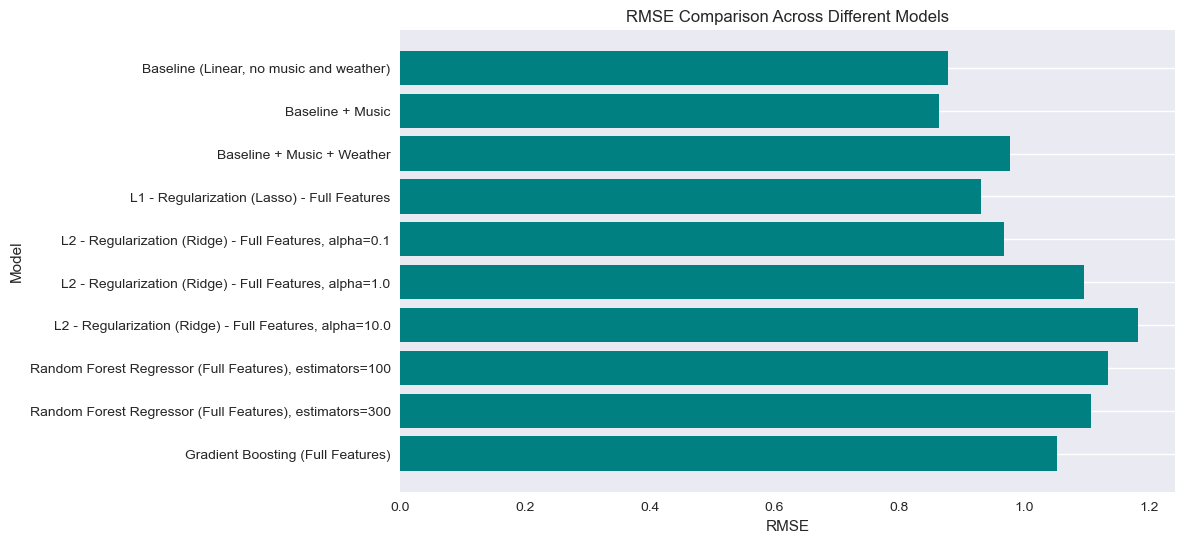

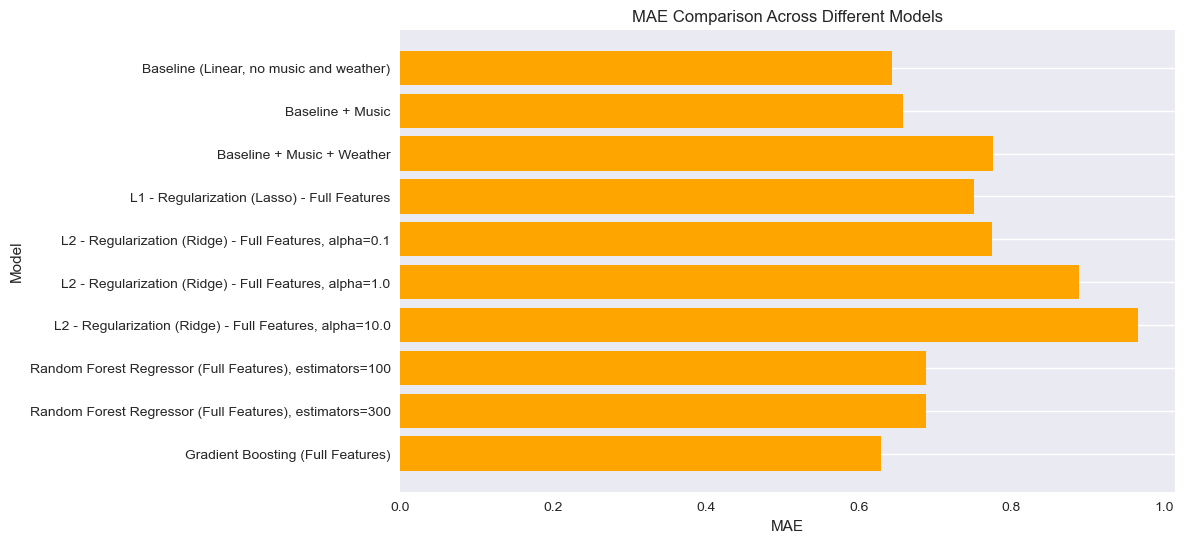

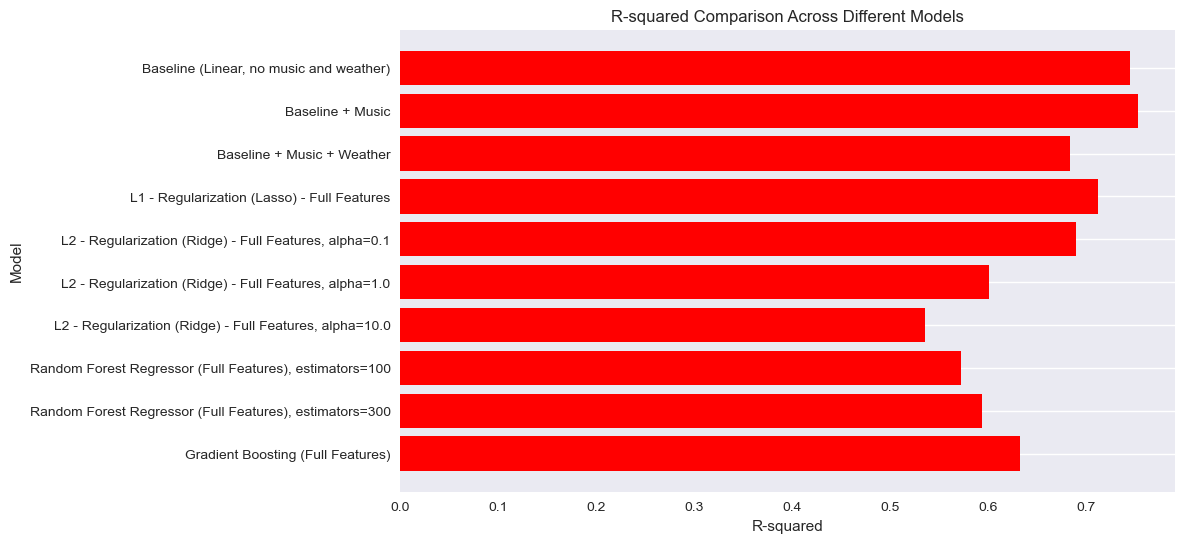

In [68]:
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(10, 6))
plt.barh(res_df["model_name"], res_df["rmse"], color="teal")
plt.gca().invert_yaxis()

plt.title("RMSE Comparison Across Different Models")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.grid(axis="x")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(res_df["model_name"], res_df["mae"], color="orange")
plt.gca().invert_yaxis()

plt.title("MAE Comparison Across Different Models")
plt.xlabel("MAE")
plt.ylabel("Model")
plt.grid(axis="x")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(res_df["model_name"], res_df["r2"], color="red")
plt.gca().invert_yaxis()

plt.title("R-squared Comparison Across Different Models")
plt.xlabel("R-squared")
plt.ylabel("Model")
plt.grid(axis="x")
plt.show()

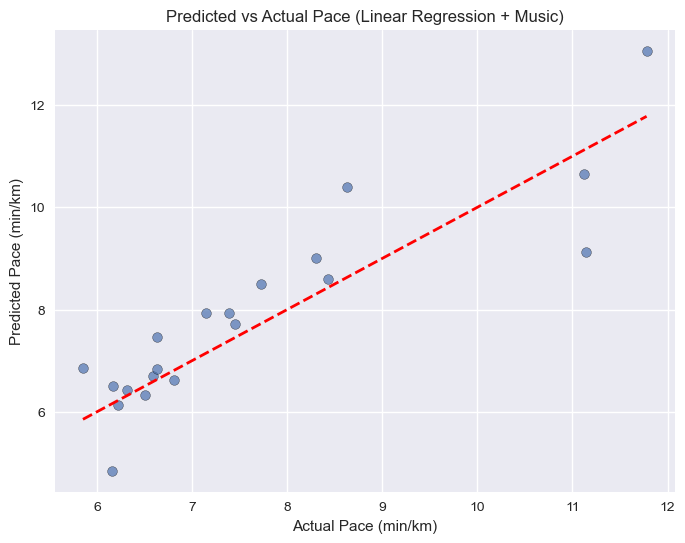

In [69]:
best_model = LinearRegression()
scaler = StandardScaler()

X_train = scaler.fit_transform(x_train_music)
X_test = scaler.transform(x_test_music)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)

plt.title("Predicted vs Actual Pace (Linear Regression + Music)")
plt.xlabel("Actual Pace (min/km)")
plt.ylabel("Predicted Pace (min/km)")
plt.grid(True)
plt.show()


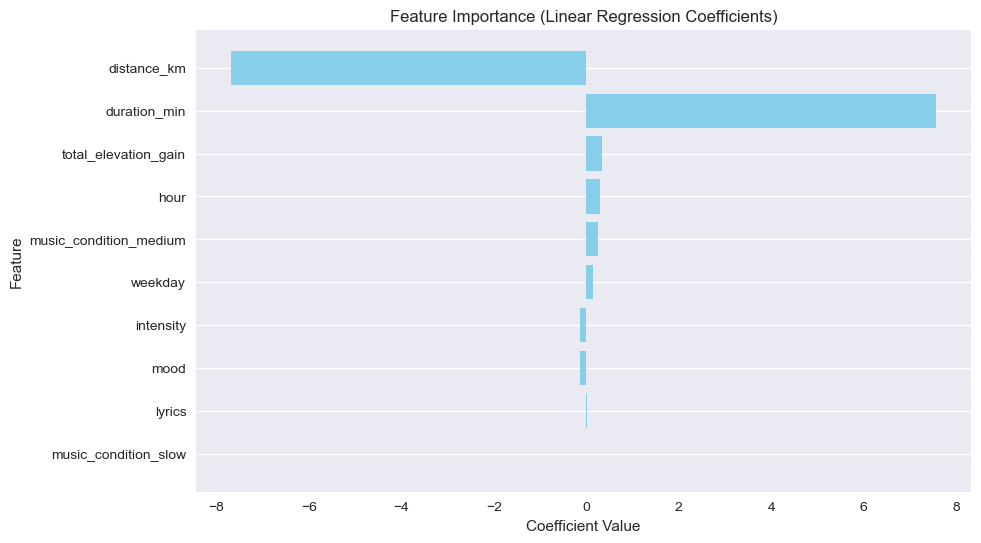

,feature,coefficient
0,distance_km,-7.679128
1,duration_min,7.558079
2,total_elevation_gain,0.331471
3,hour,0.296111
8,music_condition_medium,0.252568
4,weekday,0.146081
5,intensity,-0.129621
6,mood,-0.129621
7,lyrics,0.010779
9,music_condition_slow,-0.010779


In [70]:
# Build coefficient table
feature_names = x_train_music.columns
coefficients = best_model.coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values("coefficient", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(coef_df["feature"], coef_df["coefficient"], color="skyblue")
plt.gca().invert_yaxis()

plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()

coef_df
